<a href="https://colab.research.google.com/github/dsaldana/reinforcement-learning-course/blob/main/lab12_SAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 12: Soft Actor Critic

Train a Soft Actor-Critic (SAC) agent on HalfCheetah-v4,
track its learning curve, and compare the result with your previous RL algorithm.

We will learn to use the **stable_baselines3** library


## To start
Run the following code that solves **the Pendulum problem**

In [1]:
from lab11_MBRL import colors
# Install dependencies
!pip install "stable-baselines3[extra]" "gymnasium[classic_control]"



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


The following code trains a full SAC agent — with two critics, entropy tuning, and replay buffer — out of the box

In [2]:
import gymnasium as gym
from stable_baselines3 import SAC

# Create environment
env = gym.make("Pendulum-v1")

# Create SAC model
model = SAC("MlpPolicy", env, verbose=1)

# Train the agent with N time steps
N = 4000
model.learn(total_timesteps=N)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.55e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 311       |
|    time_elapsed    | 2         |
|    total_timesteps | 800       |
| train/             |           |
|    actor_loss      | 26.7      |
|    critic_loss     | 0.245     |
|    ent_coef        | 0.813     |
|    ent_coef_loss   | -0.337    |
|    learning_rate   | 0.0003    |
|    n_updates       | 699       |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.57e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 301       |
|    time_elapsed    | 5         |
|    total_timesteps | 1600   

# Visualize the result

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import gymnasium as gym
from stable_baselines3 import SAC
from IPython.display import HTML

env = gym.make("Pendulum-v1", render_mode="rgb_array")


N_steps = 500

frames = []
obs, _ = env.reset()
for _ in range(N_steps):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    frame = env.render()
    frames.append(frame)
    if done or truncated:
        obs, _ = env.reset()

env.close()

# Create matplotlib animation
fig = plt.figure()
img = plt.imshow(frames[0])

def animate(i):
    img.set_data(frames[i])
    return [img]

ani = animation.FuncAnimation(fig, animate, frames=len(frames), interval=30)

plt.close()
HTML(ani.to_html5_video())
ani.save("animation.mp4", writer="ffmpeg", fps=30)
print("Saved to animation.mp4")



KeyboardInterrupt



## Exercise 1: Soft Actor-Critic on HalfCheetah
**Goal:**
Adapt the existing Soft Actor-Critic (SAC) implementation from the Pendulum-v1 environment to train and evaluate a SAC agent on the more challenging HalfCheetah-v4 task.

### Instructions

1. Adapt your code: Modify your previous SAC implementation so that it runs on the HalfCheetah-v4 environment from MuJoCo.

2. Reward Logger:
Implement a custom RewardLogger callback to record episode rewards during training (you will have to search online about how to create a class for logger).
After training, use the logged data to plot the learning curve (episode reward vs. timesteps).

3. Experimentation:
    * Compare the performance of SAC on HalfCheetah-v4 with your previous algorithm.
    * Adjust the entropy temperature parameter (ent_coef or target_entropy) and observe how this affects: Exploration behavior, Convergence speed, and Final performance.

Answer the following questions
1. Did SAC reach a higher average reward or converge faster than your previous method?

2. How did changing the temperature for entropy affect the performance and stability of learning?

3. Describe any differences you observed in exploration or motion behavior of the agent.


### Deliverables

* Python notebook or script containing:
    * The adapted SAC training code
    * The RewardLogger implementation
    * Learning curve plots for SAC and your previous algorithm
    * Comparison of different entropy temperature settings

* The answer of the questions above

In [4]:
!pip install gymnasium[mujoco]


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [5]:
!pip install ipywidgets


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [35]:
import gymnasium as gym
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
import numpy as np

class RewardLogger(BaseCallback):
    def __init__(self, verbose=1):
        super().__init__(verbose)
        self.episode_rewards = []
        self.current_rewards = 0

    def _on_step(self) -> bool:
        # Collect reward
        self.current_rewards += self.locals["rewards"][0]

        # Detect end of episode
        done = self.locals["dones"][0]
        if done:
            self.episode_rewards.append(self.current_rewards)
            self.current_rewards = 0
        return True


env = gym.make("HalfCheetah-v4", render_mode=None)

N = int(100e3)

ent_temps = ['auto', 0.2, 0.01]
models={}
for temperature in ent_temps:
    model = SAC("MlpPolicy", env, verbose=1, ent_coef=temperature)
    temp = {'reward_logger': RewardLogger(),
            'model': model
            }
    models[temperature] = temp
    print('training model for temperature {}'.format(temperature))
    model.learn(total_timesteps=N, callback=models[temperature]['reward_logger'])
    nodel_file_name = "sac_halfcheetah_mujoco_{}".format(temperature)
    model.save(nodel_file_name)
    print(f"Saved model for temperature {temperature} at {nodel_file_name}")
    models[temperature]['model'] = None
    del model
    _ = env.reset()
env.close()


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
training model for temperature auto
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -236     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 268      |
|    time_elapsed    | 14       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -32.2    |
|    critic_loss     | 1.39     |
|    ent_coef        | 0.313    |
|    ent_coef_loss   | -10.9    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3899     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -219     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 267      |
|    time_elapsed    | 29       |
|    total_timestep

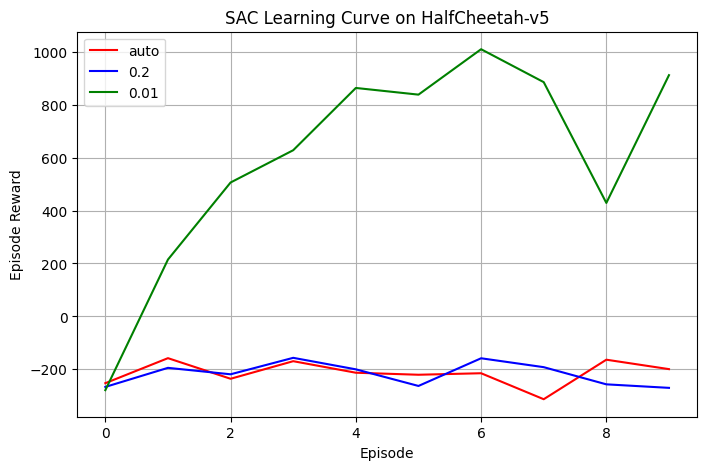

In [33]:
window_size = 5
colors = ['red', 'blue', 'green', 'purple']
plt.figure(figsize=(8,5))
for i, temperature in enumerate(ent_temps):
    rewards = models[temperature]['reward_logger'].episode_rewards
    plt.plot(rewards,
             label=temperature,
             color=colors[i]
             )
    # plt.plot(
        # np.convolve(rewards,
        #             np.ones(window_size)/window_size,
        #             mode='same'
        #             ),
        # linewidth=2,
        # # label=str(temperature) + '_mean',
        # color=colors[i]
        # )
plt.xlabel("Episode")
plt.ylabel("Episode Reward")
plt.title("SAC Learning Curve on HalfCheetah-v5")
plt.grid(True)
plt.legend()
plt.show()

In [22]:

import gymnasium as gym
from stable_baselines3 import SAC

temperature = 'auto'

# Load trained model
model = SAC.load("sac_halfcheetah_mujoco_{}".format(temperature))

# To see visualization, MuJoCo requires "render_mode='human'"
env = gym.make("HalfCheetah-v4", render_mode="human")

obs, info = env.reset()

for step in range(1000):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        obs, info = env.reset()

env.close()